In [1]:
# This code has been adapted from https://github.com/koen-aerts/ECG_ML
# %load_ext autoreload
# %autoreload 2
import wfdb
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)
from tqdm.notebook import tqdm
import neurokit2 as nk
import numpy as np
import multiprocessing
import sys, os
import sklearn
import sklearn.ensemble
import sklearn.svm
import datasets, sqis, featurization, helpers

# PICC data directory path
# Read in example signal
data_path='./data/PICC/'
datfile = data_path+'set-a/2511400'

{'record_name': '2511400', 'n_sig': 12, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 5000, 'base_time': None, 'base_date': None, 'comments': ['<age>: 58 <sex>: M'], 'sig_name': ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'p_signal': array([[-0.02 , -0.04 , -0.02 , ...,  0.   , -0.02 , -0.02 ],
       [-0.02 , -0.02 ,  0.   , ...,  0.015, -0.01 , -0.015],
       [-0.03 , -0.02 ,  0.01 , ...,  0.02 , -0.01 , -0.015],
       ...,
       [-0.015, -0.015,  0.   , ...,  0.06 ,  0.03 ,  0.02 ],
       [-0.015, -0.02 , -0.005, ...,  0.06 ,  0.02 ,  0.02 ],
       [-0.02 , -0.02 ,  0.   , ...,  0.06 ,  0.02 ,  0.02 ]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat', '2511400.dat'], 'fmt': ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', 

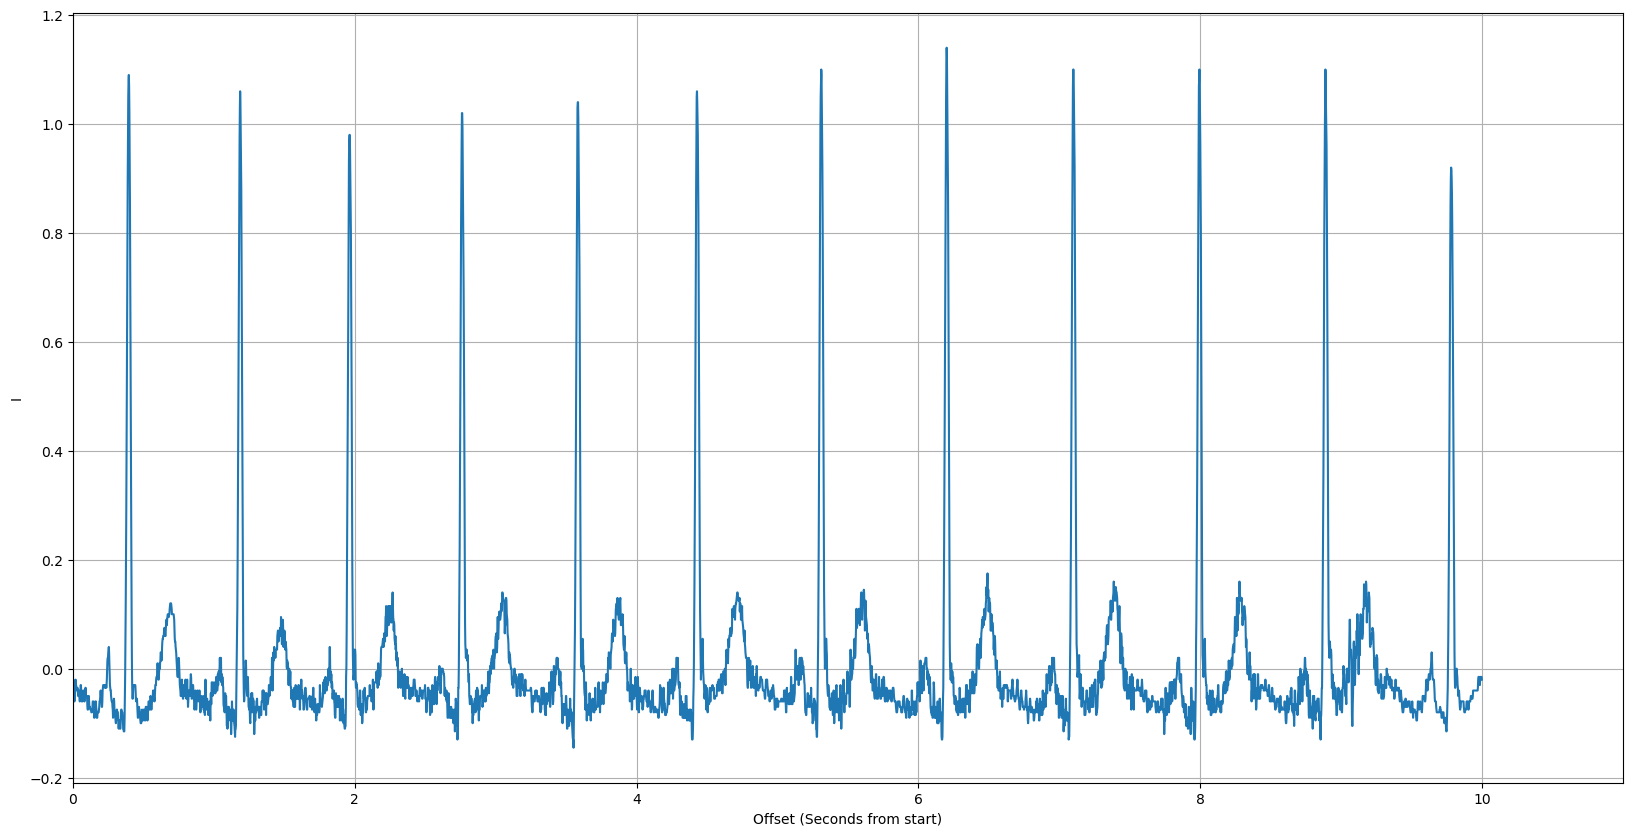

In [2]:
record = wfdb.rdrecord(datfile)
print(record.__dict__)
SAMPLE_START=0   # Start of the sample in the file.
SAMPLE_SIZE=500*10      # Number of readings (500 per second).
CHANNEL=0             # There are 2 channels
helpers.plot_signal(datfile, SAMPLE_START, SAMPLE_SIZE, CHANNEL, extract_annotation=False)

In [3]:
output_dict = datasets.load_picc(data_path=data_path, verbose=False)

X_features_dict = {'zhao2018': [],
                   'orphanidou2015': [],
                   'li2007': [],
                   'clifford2012': [],
                   'li2014': [],
                   'behar2013': [],
                   'average_qrs': [],
                   'geometric': [],
                   'all': [],
                   'y_list': [],
                   'subject': []}

# Feature detector can work with multiprocessing when imported from separate file only
X_features_dict = helpers.generate_features_dict(output_dict, X_features_dict)

998it [00:02, 425.34it/s]


  0%|          | 0/998 [00:00<?, ?it/s]

--- Method, AUC, Accuracy ---
Training on zhao2018 collection of feature metrics
method: zhao2018, np.mean(aucs): 0.5526031132132113, np.std(aucs): 0.011773496987255366, np.mean(accs): 0.7745527638190955, np.std(accs): 0.00284412344239876
Training on orphanidou2015 collection of feature metrics
method: orphanidou2015, np.mean(aucs): 0.8233112107264458, np.std(aucs): 0.028580916951739758, np.mean(accs): 0.8636591289782245, np.std(accs): 0.013204681951017552
Training on li2007 collection of feature metrics
method: li2007, np.mean(aucs): 0.797734432612822, np.std(aucs): 0.038080586354158806, np.mean(accs): 0.8617403685092129, np.std(accs): 0.014062564360601207
Training on clifford2012 collection of feature metrics
method: clifford2012, np.mean(aucs): 0.8239858512859624, np.std(aucs): 0.04363025821959375, np.mean(accs): 0.871178391959799, np.std(accs): 0.013240137657843046
Training on li2014 collection of feature metrics
method: li2014, np.mean(aucs): 0.8297457547463098, np.std(aucs): 0.04

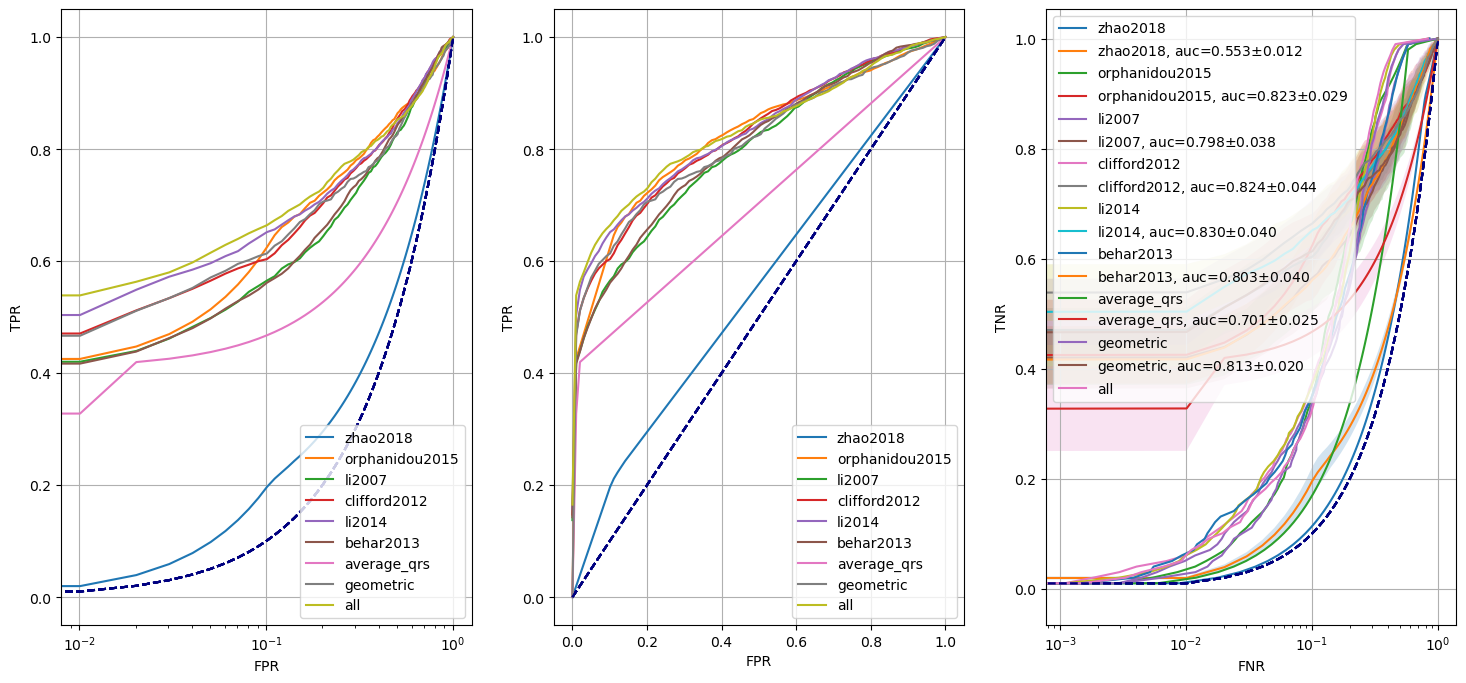

In [4]:
subjects = np.array(X_features_dict['subject'])
gkf = sklearn.model_selection.GroupKFold(n_splits=5)

plt.figure(figsize=(18,8))

print('--- Method, AUC, Accuracy ---')
for method in list(X_features_dict.keys()):
# for method in ['li2007', 'clifford2012', 'behar2013', 'li2014', 'orphanidou2015', 'average_qrs', 'zhao2018', 'geometric', 'all']:
    if method == 'y_list': continue # This is just the labels, skip as it is not a method
    if method == 'subject': continue # This is just the subject labels, skip as it is not a method
    print(f"Training on {method} collection of feature metrics")
    accs = []   # Accuracy
    tprs = []   # True Positive Rates
    mean_fpr = np.linspace(0, 1, 100) # Interpolation space for TPR
    aucs = [] # AUCs (Area Under the Curve)

    for train_split, test_split in gkf.split(subjects, groups=subjects):
        # print("%s %s" % (subjects[train_split], subjects[test_split]))
        # Prepare training and testing data
        X_train_features_cleaned = np.nan_to_num(np.array(X_features_dict[method])[train_split], nan=0.0, posinf=10000, neginf=-10000)
        X_test_features_cleaned = np.nan_to_num(np.array(X_features_dict[method])[test_split], nan=0.0, posinf=10000, neginf=-10000)
        y_train = np.array(X_features_dict['y_list'])[train_split]
        y_test = np.array(X_features_dict['y_list'])[test_split]

        # Train a Random Forest model
        model = sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=5, n_jobs=10)
        # model = sklearn.svm.SVC(random_state=0, probability=True)
        # print(method, 'X_train shape', X_train_features_cleaned.shape, 'X_test shape', X_test_features_cleaned.shape)
        model.fit(X_train_features_cleaned, y_train)

        # Predict probabilities
        scores = model.predict_proba(X_test_features_cleaned)[:,1]

        # Compute ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, scores, pos_label=1)
        accs.append(model.score(X_test_features_cleaned, y_test))
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        tprs.append(np.interp(mean_fpr, fpr, tpr))

    # Compute average TPR and AUC across folds
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    plt.subplot(1, 3, 1)
    plt.plot(mean_fpr, mean_tpr, label=method)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(); plt.legend(loc="lower right")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")
    plt.xscale('log');

    plt.subplot(1, 3, 2)
    plt.plot(mean_fpr, mean_tpr, label=method)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(); plt.legend(loc="lower right")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")

    plt.subplot(1, 3, 3)
    plt.plot(1-mean_tpr, 1-mean_fpr, label=method)
    plt.xlabel('FNR'); plt.ylabel('TNR'); plt.grid(); plt.legend(loc="upper left")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="navy", linestyle="--")
    plt.xscale('log')
    plt.plot(mean_fpr, mean_tpr, label=method+r", auc={:0.3f}$\pm${:0.3f}".format(np.mean(aucs), np.std(aucs)))
    plt.fill_between(mean_fpr, mean_tpr-std_tpr, mean_tpr+std_tpr, alpha=.2)
    # print("{}, {:0.3f} $\pm$ {:0.3f}, {:0.3f} $\pm$ {:0.3f}".format(method, np.mean(aucs), np.std(aucs), np.mean(accs), np.std(accs)))
    print(f"method: {method}, np.mean(aucs): {np.mean(aucs)}, np.std(aucs): {np.std(aucs)}, np.mean(accs): {np.mean(accs)}, np.std(accs): {np.std(accs)}")

# plt.savefig('sqi_single_lead_feats.pdf', formatstr='pdf')
plt.show()
# plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0]);
# plt.xscale('log')
# plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
# plt.legend(loc="lower right"); plt.grid()
